In [51]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image, 
    as illustrated in Figure 1.
    
    Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad -- padded image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """
    
    X_pad = np.pad(X, ((0,0), (pad,pad), (pad,pad), (0,0)), mode = 'constant', constant_values = (0,0))
    
    return X_pad

x.shape =
 (4, 3, 3, 2)
x_pad.shape =
 (4, 7, 7, 2)
x[1,1] =
 [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] =
 [[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]


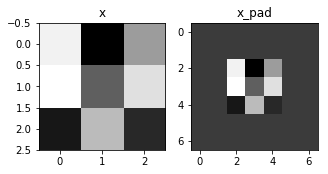

In [57]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 2)
print ("x.shape =\n", x.shape)
print ("x_pad.shape =\n", x_pad.shape)
print ("x[1,1] =\n", x[1,1])
print ("x_pad[1,1] =\n", x_pad[1,1])

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])

In [58]:
def conv_single_step(a_slice_prev, W, b):
    """
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation 
    of the previous layer.
    
    Arguments:
    a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
    W -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)
    
    Returns:
    Z -- a scalar value, the result of convolving the sliding window (W, b) on a slice x of the input data
    """

    s = a_slice_prev * W
    Z = np.sum(s)
    Z = Z + b

    return Z

In [59]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

Z = [[[-6.99908945]]]


In [60]:
def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    A_prev -- output activations of the previous layer, 
        numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
        
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """
    
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape

    (f, f, n_C_prev, n_C) = W.shape

    stride = hparameters['stride']
    pad = hparameters['pad']

    n_H = int((n_H_prev - f + 2 * pad) / stride) + 1
    n_W = int((n_W_prev - f + 2 * pad) / stride) + 1

    Z = np.zeros((m, n_H, n_W, n_C))

    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m): 
        a_prev_pad = A_prev_pad[i,:,:,:]
        for h in range(n_H):
            vert_start = h * stride
            vert_end = h * stride + f
            
            for w in range(n_W):    
                horiz_start = w * stride
                horiz_end = w * stride + f
                
                for c in range(n_C):   
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    weights = W[:,:,:,c]
                    biases = b[:,:,:,c]
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, weights, biases)
    assert(Z.shape == (m, n_H, n_W, n_C))
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

In [61]:
np.random.seed(1)
A_prev = np.random.randn(10,5,7,4)
W = np.random.randn(3,3,4,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 1,
               "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =\n", np.mean(Z))
print("Z[3,2,1] =\n", Z[3,2,1])
print("cache_conv[0][1][2][3] =\n", cache_conv[0][1][2][3])

Z's mean =
 0.692360880758
Z[3,2,1] =
 [ -1.28912231   2.27650251   6.61941931   0.95527176   8.25132576
   2.31329639  13.00689405   2.34576051]
cache_conv[0][1][2][3] =
 [-1.1191154   1.9560789  -0.3264995  -1.34267579]


In [62]:
def pool_forward(A_prev, hparameters, mode = "max"):
    """
    Implements the forward pass of the pooling layer
    
    Arguments:
    A_prev -- Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    hparameters -- python dictionary containing "f" and "stride"
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    A -- output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache used in the backward pass of the pooling layer, contains the input and hparameters 
    """

    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape

    f = hparameters["f"]
    stride = hparameters["stride"]
    
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    A = np.zeros((m, n_H, n_W, n_C))              

    for i in range(m):                      
        for h in range(n_H):            
            vert_start = h * stride
            vert_end = h * stride + f
            
            for w in range(n_W):               
                horiz_start = w * stride
                horiz_end = w * stride + f
                
                for c in range (n_C):           
                    a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
    cache = (A_prev, hparameters)
    assert(A.shape == (m, n_H, n_W, n_C))
    
    return A, cache

In [63]:
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hparameters = {"stride" : 1, "f": 3}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A.shape = " + str(A.shape))
print("A =\n", A)
print()
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A =\n", A)

mode = max
A.shape = (2, 3, 3, 3)
A =
 [[[[ 1.74481176  0.90159072  1.65980218]
   [ 1.74481176  1.46210794  1.65980218]
   [ 1.74481176  1.6924546   1.65980218]]

  [[ 1.14472371  0.90159072  2.10025514]
   [ 1.14472371  0.90159072  1.65980218]
   [ 1.14472371  1.6924546   1.65980218]]

  [[ 1.13162939  1.51981682  2.18557541]
   [ 1.13162939  1.51981682  2.18557541]
   [ 1.13162939  1.6924546   2.18557541]]]


 [[[ 1.19891788  0.84616065  0.82797464]
   [ 0.69803203  0.84616065  1.2245077 ]
   [ 0.69803203  1.12141771  1.2245077 ]]

  [[ 1.96710175  0.84616065  1.27375593]
   [ 1.96710175  0.84616065  1.23616403]
   [ 1.62765075  1.12141771  1.2245077 ]]

  [[ 1.96710175  0.86888616  1.27375593]
   [ 1.96710175  0.86888616  1.23616403]
   [ 1.62765075  1.12141771  0.79280687]]]]

mode = average
A.shape = (2, 3, 3, 3)
A =
 [[[[ -3.01046719e-02  -3.24021315e-03  -3.36298859e-01]
   [  1.43310483e-01   1.93146751e-01  -4.44905196e-01]
   [  1.28934436e-01   2.22428468e-01   1.25067597e-

In [64]:
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hparameters = {"stride" : 2, "f": 3}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A.shape = " + str(A.shape))
print("A =\n", A)
print()

A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A =\n", A)

mode = max
A.shape = (2, 2, 2, 3)
A =
 [[[[ 1.74481176  0.90159072  1.65980218]
   [ 1.74481176  1.6924546   1.65980218]]

  [[ 1.13162939  1.51981682  2.18557541]
   [ 1.13162939  1.6924546   2.18557541]]]


 [[[ 1.19891788  0.84616065  0.82797464]
   [ 0.69803203  1.12141771  1.2245077 ]]

  [[ 1.96710175  0.86888616  1.27375593]
   [ 1.62765075  1.12141771  0.79280687]]]]

mode = average
A.shape = (2, 2, 2, 3)
A =
 [[[[-0.03010467 -0.00324021 -0.33629886]
   [ 0.12893444  0.22242847  0.1250676 ]]

  [[-0.38268052  0.23257995  0.6259979 ]
   [-0.09525515  0.268511    0.46605637]]]


 [[[-0.17313416  0.32377198 -0.34317572]
   [ 0.02030094  0.14141479 -0.01231585]]

  [[ 0.42944926  0.08446996 -0.27290905]
   [ 0.15077452  0.28911175  0.00123239]]]]


In [65]:
def conv_backward(dZ, cache):
    """
    Implement the backward propagation for a convolution function
    
    Arguments:
    dZ -- gradient of the cost with respect to the output of the conv layer (Z), numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward(), output of conv_forward()
    
    Returns:
    dA_prev -- gradient of the cost with respect to the input of the conv layer (A_prev),
               numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    dW -- gradient of the cost with respect to the weights of the conv layer (W)
          numpy array of shape (f, f, n_C_prev, n_C)
    db -- gradient of the cost with respect to the biases of the conv layer (b)
          numpy array of shape (1, 1, 1, n_C)
    """

    (A_prev, W, b, hparameters) = cache
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C) = W.shape
    stride = hparameters['stride']
    pad = hparameters['pad']
    (m, n_H, n_W, n_C) = dZ.shape
    dA_prev = np.zeros(A_prev.shape)                       
    dW = np.zeros(W.shape)
    db = np.zeros((1, 1, 1, n_C))
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
    
    for i in range(m):                  
        a_prev_pad = A_prev_pad[i,:, :, :]
        da_prev_pad = dA_prev_pad[i,:, :, :]
        
        for h in range(n_H):                   
            for w in range(n_W):              
                for c in range(n_C):
                    vert_start = h * stride
                    vert_end = h * stride + f
                    horiz_start = w * stride
                    horiz_end = w* stride + f
            
                    a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]

                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                    db[:,:,:,c] += dZ[i, h, w, c]
        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]
    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))
    return dA_prev, dW, db

In [66]:
np.random.seed(1)
A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 2,
               "stride": 2}
Z, cache_conv = conv_forward(A_prev, W, b, hparameters)

dA, dW, db = conv_backward(Z, cache_conv)
print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))

dA_mean = 1.45243777754
dW_mean = 1.72699145831
db_mean = 7.83923256462


In [67]:
def create_mask_from_window(x):
    """
    Creates a mask from an input matrix x, to identify the max entry of x.
    
    Arguments:
    x -- Array of shape (f, f)
    
    Returns:
    mask -- Array of the same shape as window, contains a True at the position corresponding to the max entry of x.
    """

    mask = (x == np.max(x))

    return mask

In [69]:
np.random.seed(1)
x = np.random.randn(2,3)
mask = create_mask_from_window(x)
print('x = ', x)
print("mask = ", mask)

x =  [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
mask =  [[ True False False]
 [False False False]]


In [80]:
def distribute_value(dz, shape):
    """
    Distributes the input value in the matrix of dimension shape
    
    Arguments:
    dz -- input scalar
    shape -- the shape (n_H, n_W) of the output matrix for which we want to distribute the value of dz
    
    Returns:
    a -- Array of size (n_H, n_W) for which we distributed the value of dz
    """
 
    (n_H, n_W) = shape
    average = dz
    a = np.ones((n_H, n_W)) * average / (n_H * n_W)

    return a

In [81]:
a = distribute_value(2, (2,2))
print('distributed value =', a)

distributed value = [[ 0.5  0.5]
 [ 0.5  0.5]]


In [92]:
def pool_backward(dA, cache, mode = "max"):
    """
    Implements the backward pass of the pooling layer
    
    Arguments:
    dA -- gradient of cost with respect to the output of the pooling layer, same shape as A
    cache -- cache output from the forward pass of the pooling layer, contains the layer's input and hparameters 
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    dA_prev -- gradient of cost with respect to the input of the pooling layer, same shape as A_prev
    """
    (A_prev, hparameters) = cache

    stride = hparameters['stride']
    f = hparameters['f']

    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape
  
    dA_prev = np.zeros(A_prev.shape)
    
    for i in range(m):                      
        a_prev = A_prev[i, :, :, :]
        
        for h in range(n_H):               
            for w in range(n_W):           
                for c in range(n_C): 
                    vert_start = h * stride
                    vert_end = h * stride + f
                    horiz_start = w * stride
                    horiz_end = w* stride + f
                 
                    if mode == "max":
                        a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]
                        mask = create_mask_from_window(a_prev_slice)
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += mask * dA[i, h, w, c]
                        
                    elif mode == "average":
                        da = dA[i, h, w, c]
                        shape = (f, f)
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += distribute_value(da, shape)
    assert(dA_prev.shape == A_prev.shape)
    
    return dA_prev

In [93]:
np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
hparameters = {"stride" : 1, "f": 2}
A, cache = pool_forward(A_prev, hparameters)
dA = np.random.randn(5, 4, 2, 2)

dA_prev = pool_backward(dA, cache, mode = "max")
print("mode = max")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1])  
print()
dA_prev = pool_backward(dA, cache, mode = "average")
print("mode = average")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1]) 

mode = max
mean of dA =  0.145713902729
dA_prev[1,1] =  [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mode = average
mean of dA =  0.145713902729
dA_prev[1,1] =  [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]
